# QInfer Tomography Tutorial #

[Christopher Granade](http://www.cgranade.com/), Joshua Combes and D. G. Cory. <br>
Supplemental material to *Practical Bayesian Tomography*.
$
\newcommand{\id}{\unicode{x1D7D9}}
\newcommand{\sket}[1]{|#1\rangle\!\rangle}
\newcommand{\sbraket}[1]{\langle\!\langle#1\rangle\!\rangle}
\newcommand{\sbra}[1]{\langle\!\langle#1|}
\newcommand{\Cov}{\operatorname{Cov}}
\newcommand{\Tr}{\operatorname{Tr}}
$

## Preamble

Here, we take care of importing the various libraries that we need, as well as configuring settings needed to export this tutorial in a nice way.

In [1]:
from __future__ import division
%matplotlib inline
%config InlineBackend.figure_formats = ['png', 'pdf']

In [2]:
# This is redundant with the actual tutorial, but we use it to force
# grayscale images where supported.
import qutip as qt
qt.settings.colorblind_safe = True

In [3]:
from IPython.display import display, Latex

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
# We suppress warnings in this tutorial for ease of exporting to LaTeX.
import warnings
warnings.filterwarnings('ignore')

## Introduction

In this Notebook, we demonstrate the use of [QInfer](https://github.com/csferrie/python-qinfer) for Bayesian state and process tomography. In particular, we show how to estimate states and channels given data synthesized from a description of a true state, and discuss how to obtain region estimates, covariance superoperators and other useful functions of tomography posteriors. We then discuss how to apply these techniques in experimental systems.

The tomography implementation in QInfer is based on [QuTiP](http://qutip.org/) and [NumPy](numpy.org), so we start by importing everything here.

In [6]:
import numpy as np
import qutip as qt
import qinfer as qi

As a first step, we define a *basis* for performing tomography; the choice of basis is largely arbitrary, but depending on the experiment, some bases may be more or less convienent. Here, we focus on the example of the single-qubit Pauli basis $B = \{\id, \sigma_x, \sigma_y, \sigma_z\}$.

In [7]:
basis = qi.tomography.pauli_basis(1)
display(basis)

<TomographyBasis dims=[2] at 140700690071184>

We will get a lot of use out of the Pauli basis, so we also define some useful shorthand.

In [8]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

Basis objects are responsible for converting between QuTiP's rich ``Qobj`` format and the unstructured model parameter representation used by QInfer.

In [9]:
display(basis.state_to_modelparams(I / 2 + X / 2))

array([ 0.70710678,  0.70710678,  0.        ,  0.        ])

In [10]:
display(basis.modelparams_to_state(np.array([1, 0, 0, 1]) / np.sqrt(2)))

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0.  0.]]

Having defined a basis, we then define the core object describing a tomography experiment, the *model*. In QInfer, models encapsulate the likelihood function, experimental parameters and other useful metadata about the experimental properties being estimated. In our case, we use ``TomographyModel`` to describe the single-shot experiment, and ``BinomialModel`` to describe batches of the single-shot experiment.

In [11]:
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
display(model)

A ``Model`` defines a vector of model parameters; for a single qubit ``TomographyModel``, this is a vector of length 4, each describing a different element of the Hermitian operator basis. Each ``Model`` also defines experiment parameters as a NumPy record array. A record then describes a single measurement of the model.

In [12]:
display(model.expparams_dtype)

[('meas', float, 4), ('n_meas', 'uint')]

In this case, the experiment parameters record has two *fields*: ``meas`` and ``n_meas``. The first is a vector of four floats corresponding to $\sket{M} = (\sbraket{B_0 | M}, \sbraket{B_1 | M}, \sbraket{B_2 | M}, \sbraket{B_3 | M)}$. The second is an unsigned integer (``uint``) describing how many times that measurement is performed. For instance, measuring $(\id + \sigma_z) / 2$ 40 times is given by the array:

In [13]:
expparams = np.array([
    # Each tuple, marked with (), defines a single record.
    (
        # Within each tuple, fields are separated by commas.
        # The fields follow in the order given by the model,
        # so the first field is meas, a length-4 vector.
        [1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)],
        # The second field is then the number of measurements.
        40
    )
],
# We finish building the array by passing along the right data\
# type to NumPy. This is somwhat of a QInfer idiom.
dtype=model.expparams_dtype)
display(expparams)

array([([0.7071067811865475, 0.0, 0.0, 0.7071067811865475], 40L)], 
      dtype=[('meas', '<f8', (4,)), ('n_meas', '<u8')])

The fields of a record array can be obtained by indexing. For instance, the ``['meas']`` field is then a $1 \times 4$ array, with the first index allowing for a sequence of measurements to be described at once.

In [14]:
display(expparams['meas'])

array([[ 0.70710678,  0.        ,  0.        ,  0.70710678]])

Note that  by convention, ``meas`` is normalized to $1 / \sqrt{d}$.

Often, we will not construct experiments directly, but will instead rely on QInfer's heuristics (described below). In any case, once we have a model, the next step is to create a prior. QInfer comes with several useful fiducial priors, as well as insightful priors constructed from amplitude damping channels. For instance, to create a Hilbert-Schmidt uniform prior constrained to rebits, we use the ``GinibreReditDistribution``:

In [15]:
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)

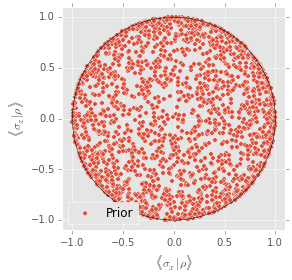

In [16]:
qi.tomography.plotting_tools.plot_rebit_prior(fiducial_prior, rebit_axes=[1, 3])

Here, we have told QInfer that we wish to treat $\sigma_x$ and $\sigma_z$ as our rebit axes using the ``rebit_axes=[1, 3]`` argument.

Insightful priors can be constructed by specifying a fiducial prior and a QuTiP ``Qobj`` representing the desired mean.

In [17]:
prior_mean = (I + (2/3) * Z + (1/3) * X) / 2
display(prior_mean)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.83333333  0.16666667]
 [ 0.16666667  0.16666667]]

In [18]:
prior = qi.tomography.GADFLIDistribution(fiducial_prior, prior_mean)

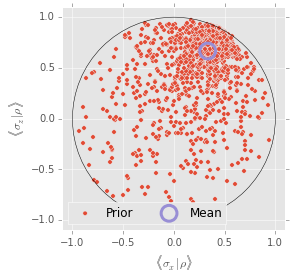

In [19]:
qi.tomography.plotting_tools.plot_rebit_prior(prior, rebit_axes=[1, 3])

Having constructed a prior and a model, we can now continue to perform Bayesian inference using SMC. We demonstrate using the true state $\rho = \id / 2 + (2 / 3) \sigma_z / 2$ with the prior mean $\rho_\mu = [\id + (4/5) \sigma_z + (1/7)\sigma_x] / 2$.

In [31]:
basis = qi.tomography.pauli_basis(1)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
true_state = basis.state_to_modelparams(
    I / 2 + (2 / 3) * Z / 2
)[np.newaxis, :]
fiducial_prior = qi.tomography.GinibreReditDistribution(basis)
prior = qi.tomography.GADFLIDistribution(fiducial_prior,
    I / 2 + (4 / 5) * Z / 2 + (1 / 7) * X / 2
)

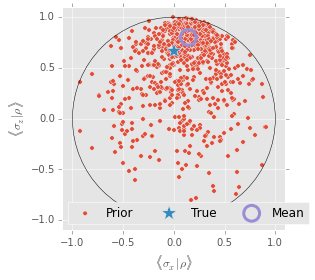

In [32]:
qi.tomography.plotting_tools.plot_rebit_prior(prior, true_state=true_state, rebit_axes=[1, 3])

The updater and heuristic classes track the posterior and the random-measurement experiment design, respectively.

In [33]:
updater = qi.smc.SMCUpdater(model, 2000, prior)
heuristic = qi.tomography.RandomPauliHeuristic(updater, other_fields={'n_meas': 40})

We synthesize data for the true state, then feed it into the updater in order to obtain our final posterior.

In [34]:
for idx_exp in xrange(50):
    experiment = heuristic()
    datum = model.simulate_experiment(true_state, experiment)
    updater.update(datum, experiment)

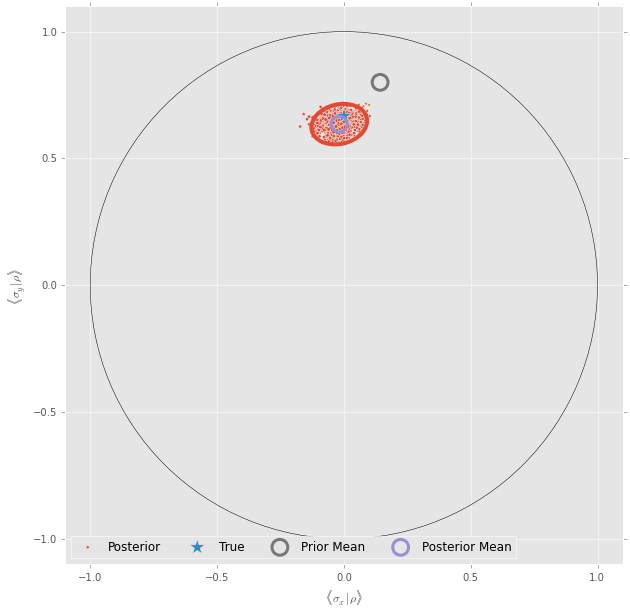

In [35]:
plt.figure(figsize=(10, 10))
qi.tomography.plotting_tools.plot_rebit_posterior(
    updater, prior, true_state,
    rebit_axes=[1, 3]
)

We can use our tomography basis object to read out the estimated final state as a QuTiP ``Qobj``.

In [25]:
est_mean = basis.modelparams_to_state(updater.est_mean())
display(est_mean)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.81441676  0.01355679]
 [ 0.01355679  0.18558324]]

As discussed in the main text, the posterior can also be described by the covariance superoperator $\Sigma \rho = \Cov(\sket{\rho})$. We demonstrate by showing the Choi matrix $J(\Cov(\sket{\rho}))$.

In [26]:
cov_superop = basis.covariance_mtx_to_superop(updater.est_covariance_mtx())
display(qt.to_choi(cov_superop))
display(Latex(r"$\|\Sigma\rho\|_{{\Tr}} = {:0.4f}$".format(cov_superop.norm('tr'))))

Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = [4, 4], type = super, isherm = True, superrep = choi
Qobj data =
[[  2.85381005e-04   1.62164180e-05   1.62164180e-05   3.21044561e-04]
 [  1.62164180e-05  -2.85381005e-04   3.21044561e-04  -1.62164180e-05]
 [  1.62164180e-05   3.21044561e-04  -2.85381005e-04  -1.62164180e-05]
 [  3.21044561e-04  -1.62164180e-05  -1.62164180e-05   2.85381005e-04]]

<IPython.core.display.Latex object>

Here, we use the Hinton diagram plotting functionality provided by QuTiP to depict the covariance in each observable that we obtain from the posterior.

(<matplotlib.figure.Figure at 0x18218a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18209f98>)

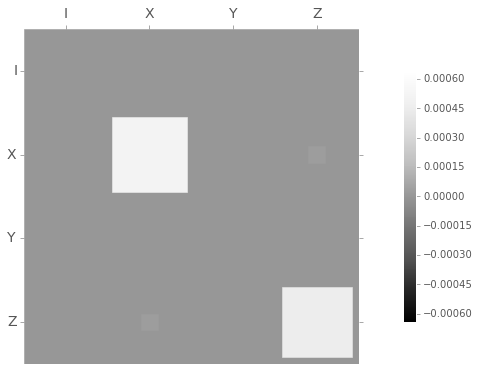

In [27]:
display(qt.visualization.hinton(cov_superop))